<a href="https://colab.research.google.com/github/dariakrtn/ML_Autofill_the_search_bar/blob/main/delivery_automatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploratory data analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

from string import printable
import re
import os
from IPython.display import clear_output


In [2]:
collab_env = True
if collab_env:
    from google.colab import drive

    ROOT_DIR = '/content/drive'
    RANDOM_SEED = 42
    drive.mount(ROOT_DIR)
    DRIVE_DATA_DIR = 'ml_data'
    root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
    # in the case of local file systen
    root_data_dir = '/srv/data/'

clear_output()
data_version = '2023_08_06'
print()
print("Content in root_data_dir %s:\n%s" % (root_data_dir, [i for i in os.listdir(root_data_dir)]))


Content in root_data_dir /content/drive/MyDrive/ml_data:
['data_sg']


In [3]:
!ls /content/drive/MyDrive/data_sg

ls: cannot access '/content/drive/MyDrive/data_sg': No such file or directory


In [4]:
products_data_full = (
    pd.read_csv(
        os.path.join(root_data_dir, 'data_sg', 'products_sg.txt'),
        index_col=0
    )
)

products_data_full.head(10)

,vendor_id,product_id,name,unit_price
0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024
3,7112a20b,d3e7708c2bc9,Maguro Sushi,0.0012
4,6137ef21,bf0d5ac0e03c,Family Meal - Prosp Chic TwLEVMx2 + ChBurgerHM,0.0100
5,6fb36d6f,b40fab1ad16c,Deep-fried Squid 炸苏东仔,0.0068
6,cf5624ba,cd353b5f4d36,Braised Bean Curd Soup 金汤黄焖鱼腐,0.0060
7,590b8f67,a5d5c3ef8927,Garlic Bread,0.0004
8,e173c5ad,1f348eecfae2,Grilled Cheese Abalone and Aburi Salmon,0.0040
9,7f84f917,5ea2fec17811,Cappuccino,0.0024


In [5]:
products_data_full.isna().sum()

vendor_id     0
product_id    0
name          0
unit_price    0
dtype: int64

In [6]:
products_data_full["name"].value_counts()

Coke                                               1685
Sprite                                             1441
Cutlery - No                                       1173
Large                                              1100
Medium                                             1046
                                                   ... 
Dead Guy Ale                                          1
1082. Green Curry Fried Rice 绿咖喱炒饭                    1
鱼香肉丝 Shredded Pork & Sweet & Sour Sauce               1
1072. Fried Cabbage with Chinese Mushroom 包菜炒香菇       1
Gula Melaka Sago 椰糖西米露                                1
Name: name, Length: 274915, dtype: int64

In [8]:
products_data_full.shape

(1066840, 4)

In [9]:
products_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1066840 entries, 0 to 1066839
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   vendor_id   1066840 non-null  object 
 1   product_id  1066840 non-null  object 
 2   name        1066840 non-null  object 
 3   unit_price  1066840 non-null  float64
dtypes: float64(1), object(3)
memory usage: 40.7+ MB


In [11]:
products_data_full.nunique()

vendor_id        7411
product_id    1066823
name           274915
unit_price        446
dtype: int64

In [27]:
data_uniq_product = products_data_full.drop_duplicates(subset='name')
data_uniq_product.head(10)

,vendor_id,product_id,name,unit_price
0,15bbf316,59099e089514,Meat & Seafood Combo 海鲜套餐,0.0036
1,e7b24dc0,52e1017fdbd9,Sausage Egg McMuffin® Meal,0.0024
2,e7b24dc0,fcb7110cd932,Scrambled Egg Burger w Chicken Meal,0.0024
3,7112a20b,d3e7708c2bc9,Maguro Sushi,0.0012
4,6137ef21,bf0d5ac0e03c,Family Meal - Prosp Chic TwLEVMx2 + ChBurgerHM,0.0100
5,6fb36d6f,b40fab1ad16c,Deep-fried Squid 炸苏东仔,0.0068
6,cf5624ba,cd353b5f4d36,Braised Bean Curd Soup 金汤黄焖鱼腐,0.0060
7,590b8f67,a5d5c3ef8927,Garlic Bread,0.0004
8,e173c5ad,1f348eecfae2,Grilled Cheese Abalone and Aburi Salmon,0.0040
9,7f84f917,5ea2fec17811,Cappuccino,0.0024


In [17]:
data_uniq_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274915 entries, 0 to 1066836
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   vendor_id   274915 non-null  object 
 1   product_id  274915 non-null  object 
 2   name        274915 non-null  object 
 3   unit_price  274915 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.5+ MB


In [18]:
data_uniq_product["name"].value_counts()

Meat & Seafood Combo 海鲜套餐                   1
Insalata Di Cavolo                          1
Olive Rice (Most popular)                   1
Lychee Sorbet                               1
Additional Noodles with Broth               1
                                           ..
(01-18) Satay beehoon (Small)               1
(01-04) Fried Fish Soup                     1
(01-29) Pork Ribs w Liver Noodle            1
(01-10) Bitter Gourd with Pork Ribs Soup    1
Gula Melaka Sago 椰糖西米露                      1
Name: name, Length: 274915, dtype: int64

In [19]:
df=data_uniq_product.drop(columns=["vendor_id","product_id", "unit_price"])

In [20]:
df.head(10)

,name
0,Meat & Seafood Combo 海鲜套餐
1,Sausage Egg McMuffin® Meal
2,Scrambled Egg Burger w Chicken Meal
3,Maguro Sushi
4,Family Meal - Prosp Chic TwLEVMx2 + ChBurgerHM
5,Deep-fried Squid 炸苏东仔
6,Braised Bean Curd Soup 金汤黄焖鱼腐
7,Garlic Bread
8,Grilled Cheese Abalone and Aburi Salmon
9,Cappuccino


### Preprocessing


In [34]:
def preprocess_text(name):
    name = name.replace("-", "")
    name = name.replace("®", "")
    name = name.replace("&", "")
    name = name.replace("+", "")
    name = re.sub(r"[^A-Za-z]+", " ", name)
    name = re.sub(r"I\d\d\. ", "", name)
    name = re.sub("(^.+\. )", "", name)
    name = re.sub("([\(\[]).*?([\)\]])", "", name)
    name = re.sub('\$(.*)', "", name)
    name = re.sub("\s+", " ", name)
    name = name.lower().strip()
    return name

In [35]:
name_processed = [preprocess_text(q) for q in df['name']]
name_processed = [q for q in name_processed if len(q) != 0] # remove empty strings after preprocessing

In [111]:
len(name_processed)

274684

### Remove modifiers and long


In [37]:
q.remove("Large")
q.remove("Medium")
q.remove("Small")
q_lengths = [len(q) for q in name_processed]

<ipython-input-38-89f6e082e638>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(q_lengths)


<Axes: ylabel='Density'>

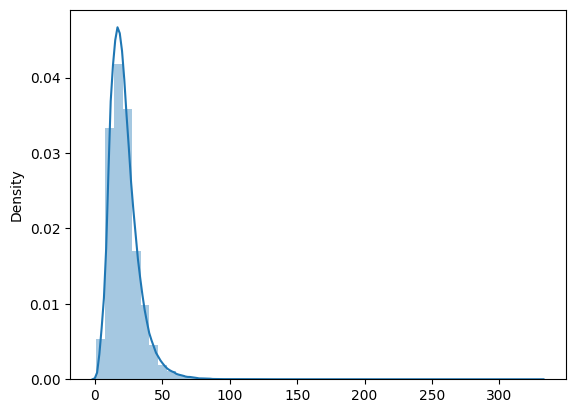

In [38]:
sns.distplot(q_lengths)

In [39]:
mean = np.mean(q_lengths)
std = np.std(q_lengths)
print(f"mean: {mean}, std: {std}")

mean: 21.83599700018931, std: 11.114757558375876


In [40]:
optimum_length = int(mean + std)
print(f"optimum length: {optimum_length}")

optimum length: 32


In [41]:
name_short = [q for q in name_processed if len(q) <= optimum_length and len(q) > 3]

### Shuffle Data

In [42]:
import random
random.seed(42)
random.shuffle(name_short)

### Create Dataset and Dataloader


Here we create the vocab, encode as char indices, and perform one-hot encoding and padding

In [43]:
class NameDataset(Dataset):
    def __init__(self, name, vocab, sos_token, eos_token, batch_first=False):

        # initialize parameters
        self.sos_idx = 0
        self.eos_idx = 1
        self.int2char = {self.sos_idx: sos_token, self.eos_idx: eos_token} # insert start of sentence and end of sentence tokens
        self.int2char.update({idx: char for idx, char in enumerate(vocab, start=self.eos_idx+1)})
        self.char2int = {char: idx for idx, char in self.int2char.items()}
        self.n_chars = len(self.int2char)

        # encode and pad name
        self.name_encoded = pad_sequence([self.encode_question(q) for q in name], \
                                              batch_first=batch_first)

    def __len__(self):
        return len(self.name_encoded)

    def __getitem__(self, idx):
        return self.name_encoded[idx]

    def encode_question(self, question):
        '''
        encode as char indices and perform one-hot encoding
        '''
        name_encoded = [self.sos_idx] # append sos
        for char in question:
            name_encoded.append(self.char2int[char])
        name_encoded.append(self.eos_idx) # append eos
        return F.one_hot(torch.tensor(name_encoded, dtype=torch.long), self.n_chars).float()

In [44]:
vocab = sorted(set("".join(name_short)))
sos_token = '['
eos_token = ']'
BATCH_FIRST=True
BATCH_SIZE=512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create train and val set

In [47]:
val_percent = 0.2
n_val = int(val_percent * len(name_short))
n_train = len(name_short) - n_val
print(f"train: {n_train}, val: {n_val}")

train: 189692, val: 47423


In [48]:
name_train = name_short[:n_train]
name_val = name_short[n_train:]

In [49]:
train_dataset = NameDataset(name_train, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)
val_dataset = NameDataset(name_val, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
assert train_dataset.n_chars == val_dataset.n_chars

## Data Science

### Define Model

In [51]:
class charRNN(nn.Module):

    def __init__(self, VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS=2, P_DROPOUT=0.5, batch_first=False):
        super().__init__()
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.lstm = nn.LSTM(VOCAB_SIZE, HIDDEN_SIZE, batch_first=batch_first,
                            dropout=P_DROPOUT, num_layers=N_LAYERS)
        self.dropout = nn.Dropout(P_DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)

    def forward(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)

        # flatten the lstm output
        lstm_out = torch.flatten(lstm_out, start_dim=0, end_dim=1)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, BATCH_SIZE, device):
        hidden = (torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device),
                  torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device))
        return hidden

In [52]:
VOCAB_SIZE=train_dataset.n_chars
HIDDEN_SIZE=512
N_LAYERS=3
P_DROPOUT = 0.4

In [53]:
model = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS, P_DROPOUT, BATCH_FIRST)

### Train the model

In [54]:
model.to(device=device)

charRNN(
  (lstm): LSTM(29, 512, num_layers=3, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=29, bias=True)
)

In [76]:
n_epochs = 6
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
clip = 5

save_dir = "./saved_models"
save_epoch = 5

In [60]:
import os
from tqdm import tqdm

In [77]:
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(1, n_epochs+1)):

    # training
    # -------------

    n_batches_train = 0
    cummulative_loss_train = 0

    model.train()

    # initialize hidden state
    hidden = model.init_hidden(BATCH_SIZE, device)

    for data_batch in train_dataloader:

        # detach hidden state
        hidden = tuple([h.detach() for h in hidden])

        if data_batch.shape[0] != BATCH_SIZE:
            continue

        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        preds, hidden = model(labels, hidden)
        # compute loss
        target_idx = torch.argmax(targets, dim=2).long()
        target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
        train_loss = loss(preds, target_flatten)

        # backpropagation
        optimizer.zero_grad()
        train_loss.backward()

        # clip the gradient before updating the weights
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        n_batches_train += 1
        cummulative_loss_train += train_loss.item()

    loss_per_epoch_train = cummulative_loss_train / n_batches_train
    train_loss_list.append(loss_per_epoch_train)

    # validation
    # ---------------

    n_batches_val = 0
    cummulative_loss_val = 0

    model.eval()
    hidden = model.init_hidden(BATCH_SIZE, device)

    for data_batch in val_dataloader:

        if data_batch.shape[0] != BATCH_SIZE:
            continue

        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        with torch.no_grad():
            preds, hidden = model(labels, hidden)
            # compute loss
            target_idx = torch.argmax(targets, dim=2).long()
            target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
            val_loss = loss(preds, target_flatten)

        n_batches_val += 1
        cummulative_loss_val += val_loss.item()

    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)

    # # save model every 10 epochs
    if epoch % save_epoch == 0:
        model_name = f"charRNN_questions_epoch_{epoch}.pt"
        save_path = os.path.join(save_dir, model_name)
        torch.save(model.state_dict(), save_path)

100%|██████████| 6/6 [06:48<00:00, 68.09s/it]


### Plot the curves

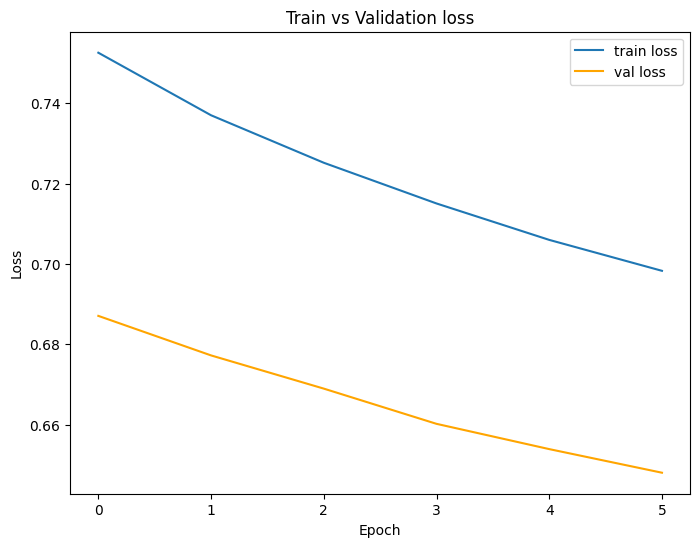

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.set_title("Train vs Validation loss")

plt.legend()

In [79]:
class GenerateText:
    def __init__(self, model, k, int2char, char2int, device):
        self.int2char = int2char
        self.char2int = char2int
        self.n_chars = len(int2char)
        self.model = model
        self.device = device
        self.k = k
        self.sos_token = self.int2char[0]
        self.eos_token = self.int2char[1]

    def predict_next_char(self, hidden, input_char):

        # encode char
        char_one_hot = self.encode_char(input_char)

        # get the predictions
        with torch.no_grad():
            out, hidden = self.model(char_one_hot, hidden)

            # convert the output to a character probability distribution
            p = F.softmax(out, dim=1)

            # move to cpu as numpy doesn't support gpu
            p = p.cpu()

            # get top k characters from the distribution
            values, indices = p.topk(self.k)

        indices = indices.squeeze().numpy()
        values = values.squeeze().numpy()

        # sample any char from the top k chars using the output softmax distribution
        char_pred = np.random.choice(indices, size=1, p=values/values.sum())

        return self.int2char[char_pred[0]], hidden

    def generate_text(self, prime, max_chars=80):

        prime = self.sos_token + prime

        all_chars = [char for char in prime]
        hidden = model.init_hidden(1, self.device)

        # build up the hidden state using the initial prime
        for char in prime:
            char_pred, hidden = self.predict_next_char(hidden, char)

        all_chars.append(char_pred)

        # generate n chars
        c = len(all_chars)
        while char_pred != self.eos_token:
            if c == max_chars:
                break
            char_pred, hidden = self.predict_next_char(hidden, all_chars[-1])
            all_chars.append(char_pred)
            c += 1

        return "".join(all_chars)

    def encode_char(self, char):
        char_int = self.char2int[char]
        char_one_hot = F.one_hot(torch.tensor(char_int), self.n_chars).float()
        return char_one_hot.unsqueeze(0).unsqueeze(0).to(self.device)

In [64]:
k = 3

In [80]:
text_generator = GenerateText(model, k, train_dataset.int2char, train_dataset.char2int, device)

In [86]:
text_generator.generate_text('sushi', max_chars=optimum_length)

'[sushi mini combo]'

In [96]:
text_generator.generate_text('fish', max_chars=optimum_length)

'[fish curry rice]'

In [110]:
text_generator.generate_text('cap', max_chars=optimum_length)

'[cappuccino super]'